In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import time
import xgboost as xgb

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

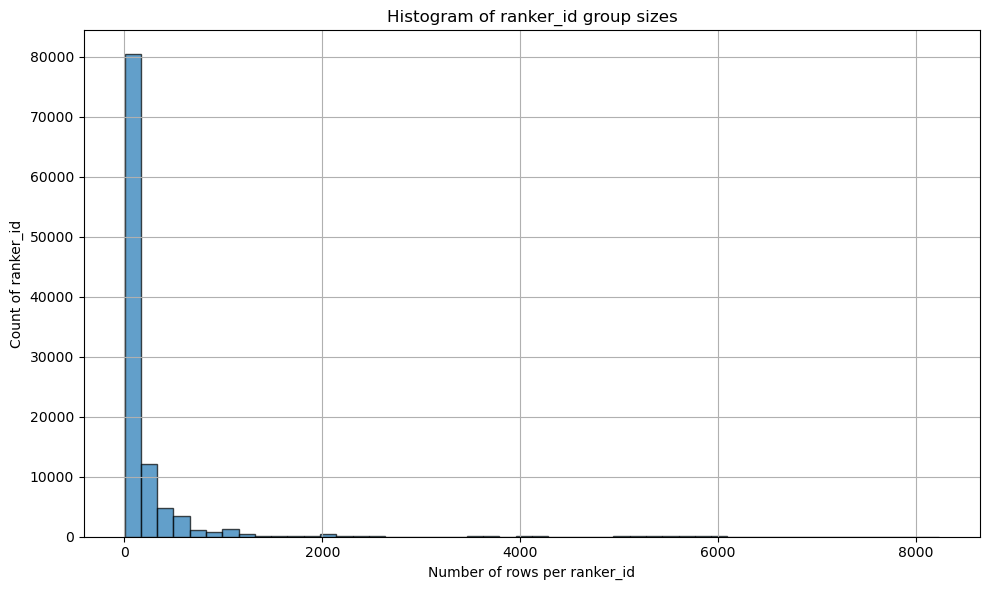

In [2]:
import polars as pl
import matplotlib.pyplot as plt

# Load data
train = pl.read_parquet('data/train_filled.parquet')

# 計算每個 ranker_id 出現次數
ranker_counts = (
    train
    .group_by("ranker_id")
    .agg(pl.len().alias("n_rows"))
    .sort("n_rows")
)

# 轉成 pandas
ranker_counts_pd = ranker_counts.to_pandas()

# 畫 histogram
plt.figure(figsize=(10,6))
plt.hist(ranker_counts_pd["n_rows"], bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Number of rows per ranker_id")
plt.ylabel("Count of ranker_id")
plt.title("Histogram of ranker_id group sizes")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
ranker_counts_filtered = ranker_counts.filter(pl.col("n_rows") >= 3)
summary_filtered = ranker_counts_filtered.select([
    pl.col("n_rows").min().alias("min"),
    pl.col("n_rows").max().alias("max"),
    pl.col("n_rows").mean().alias("mean"),
    pl.col("n_rows").median().alias("median"),
    pl.col("n_rows").quantile(0.25, "nearest").alias("25%"),
    pl.col("n_rows").quantile(0.75, "nearest").alias("75%"),
    pl.col("n_rows").std().alias("std"),
])

print(summary_filtered)


shape: (1, 7)
┌─────┬──────┬────────────┬────────┬──────┬───────┬────────────┐
│ min ┆ max  ┆ mean       ┆ median ┆ 25%  ┆ 75%   ┆ std        │
│ --- ┆ ---  ┆ ---        ┆ ---    ┆ ---  ┆ ---   ┆ ---        │
│ u32 ┆ u32  ┆ f64        ┆ f64    ┆ f64  ┆ f64   ┆ f64        │
╞═════╪══════╪════════════╪════════╪══════╪═══════╪════════════╡
│ 3   ┆ 8236 ┆ 177.851194 ┆ 53.0   ┆ 21.0 ┆ 162.0 ┆ 452.477068 │
└─────┴──────┴────────────┴────────┴──────┴───────┴────────────┘


In [1]:
import os
import pandas as pd

def load_label_features(
    model_dir: str,
    split_labels: list,
    top_n: int = None
):
    """
    從模型資料夾讀取每個分群的特徵重要性檔案，回傳每個label的features list。
    
    參數:
    - model_dir: 模型資料夾
    - split_labels: 分群名稱list
    - top_n: 如果指定，只取前N個特徵；否則用第一個min_rank=9999為止

    回傳:
    - dict(label -> features list)
    """
    label_features = {}

    for label in split_labels:
        model_importance_dir = os.path.join(model_dir, "model_importance")
        csv_path = os.path.join(model_importance_dir, f"feature_importance_{label}_all_features.csv")

        df = pd.read_csv(csv_path)

        if top_n is not None:
            # 直接取前top_n
            feats = df.iloc[:top_n]["feature"].tolist()
            print(f"\n✅ {label}: 取前 {top_n} 個特徵")
        else:
            idx_first_unused = df[df["min_rank"] == 9999].index.min()
            feats = df["feature"].tolist()
            exclude_cols = {"n_rows", "group_category"}
            feats = [f for f in feats if f not in exclude_cols]

            print(f"\n✅ {label}: 第 {idx_first_unused} 名後都是完全未使用的特徵")
            print("✅ 第一個未使用特徵：")
            print(df.iloc[idx_first_unused])

        label_features[label] = feats

    # 印出所有分群features數量
    for label in split_labels:
        print(f"{label}: {len(label_features[label])} features")

    return label_features


In [2]:

model_dir = "model_output/all_features_xgb"

# 先把每個分群都讀一遍feature importance
split_labels = ["small", "medium", "large", 'xlarge']

label_features = load_label_features(
    model_dir=model_dir,
    split_labels=split_labels)



✅ small: 第 155 名後都是完全未使用的特徵
✅ 第一個未使用特徵：
feature            legs0_segments2_departureFrom_airport_iata
weight                                                    NaN
weight_rank_pos                                        9999.0
gain                                                      NaN
gain_rank_pos                                          9999.0
cover                                                     NaN
cover_rank_pos                                         9999.0
min_rank                                               9999.0
Name: 155, dtype: object

✅ medium: 第 165 名後都是完全未使用的特徵
✅ 第一個未使用特徵：
feature            legs0_segments3_marketingCarrier_code_in_ff
weight                                                     NaN
weight_rank_pos                                         9999.0
gain                                                       NaN
gain_rank_pos                                           9999.0
cover                                                      NaN
cover_rank_pos    

In [ ]:
import numpy as np
import polars as pl

# 讀取
train_filled = pl.read_parquet("data/train_filled.parquet")

# 排除欄
needed_cols = [
    'Id', 'ranker_id', 'selected'
]
remove = ['profileId', 'requestDate',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt', "n_rows", "__index_level_0__"]

exclude_cols = needed_cols + remove

feature_cols = [c for c in train_filled.columns if c not in exclude_cols]

# 轉 float32
float64_cols = [c for c in feature_cols if train_filled[c].dtype == pl.Float64]
train_filled = train_filled.with_columns(
    [pl.col(c).cast(pl.Float32) for c in float64_cols]
)

all_features = feature_cols+needed_cols
train_filled = train_filled.select(all_features)

In [7]:
# 找字串欄
str_cols = [c for c in train_filled.columns if train_filled[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in train_filled.columns if train_filled[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in train_filled.columns if train_filled[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 2 個字串欄位
✅ 共找到 229 個數值欄位
✅ 共找到 0 個布林欄位


In [2]:
import polars as pl
import os
import gc

def split_data_by_group_size(
    df: pl.DataFrame,
    bins: list,
    labels: list,
    output_dir: str,
    label_features: dict = None,
    unused_label_features: dict = None
):
    """
    分群 + 分批寫檔 + 釋放記憶體。

    df: polars.DataFrame
    bins: 分群邊界
    labels: 分群名稱
    output_dir: 每個群的 parquet 儲存目錄
    label_features: dict(label -> feature list)
    unused_label_features: dict(label -> feature list)，要排除的欄位
    """
    os.makedirs(output_dir, exist_ok=True)

    df = df.with_row_count("global_row_nr")

    group_counts = (
        df.group_by("ranker_id")
          .agg(pl.count().alias("n_rows"))
          .filter(pl.col("n_rows") >= bins[0])
    )

    bins_fixed = bins.copy()
    if bins_fixed[-1] is None:
        max_value = group_counts["n_rows"].max()
        bins_fixed[-1] = int(max_value) + 1

    if len(labels) != len(bins_fixed) - 1:
        raise ValueError(f"bins={bins_fixed} 有 {len(bins_fixed)-1}個區間，但labels數={len(labels)}")

    cond = (
        pl.when((pl.col("n_rows") >= bins_fixed[0]) & (pl.col("n_rows") < bins_fixed[1]))
        .then(pl.lit(labels[0]))
    )
    for i in range(1, len(labels)):
        cond = cond.when(
            (pl.col("n_rows") >= bins_fixed[i]) & (pl.col("n_rows") < bins_fixed[i+1])
        ).then(pl.lit(labels[i]))
    cond = cond.otherwise(pl.lit("unknown"))

    group_counts = group_counts.with_columns([
        cond.alias("group_category")
    ])

    df = df.join(group_counts, on="ranker_id", how="left")

    written_files = []
    effective_label_features = {}

    for lbl in labels:
        subset = df.filter(pl.col("group_category") == lbl)

        if subset.is_empty():
            print(f"⚠️ {lbl} 沒有資料，跳過")
            continue

        # 計算要用的特徵
        if label_features is None:
            feats = [c for c in df.columns if c != "group_category"]
        else:
            feats = label_features.get(lbl, [])

        # 排除 unused features
        if unused_label_features is not None:
            if isinstance(unused_label_features, dict):
                unused_feats = set(unused_label_features.get(lbl, []))
            elif isinstance(unused_label_features, list):
                unused_feats = set(unused_label_features)
            else:
                raise ValueError("unused_label_features 必須是 dict 或 list")
            
            # ⚠️ 把這行補回來：實際刪除
            feats = [f for f in feats if f not in unused_feats]



        # 記錄實際使用的特徵
        effective_label_features[lbl] = feats

        base_cols = ["selected", "ranker_id", "global_row_nr"]
        all_cols = feats + base_cols
        all_cols = list(dict.fromkeys(all_cols))

        subset = subset.select([c for c in all_cols if c in subset.columns])

        mem_mb = subset.estimated_size() / (1024 * 1024)
        print(f"✅ {lbl}: {subset.height} rows, approx {mem_mb:.2f} MB")

        out_path = os.path.join(output_dir, f"{lbl}.parquet")
        subset.write_parquet(out_path)
        print(f"💾 已寫入 {out_path}")
        written_files.append(out_path)

        del subset
        gc.collect()

    summary = (
        group_counts.group_by("group_category")
        .agg([
            pl.count().alias("n_groups"),
            pl.col("n_rows").sum().alias("total_rows"),
            pl.col("n_rows").mean().alias("avg_rows_per_group")
        ])
        .sort("group_category")
    )

    print("✅ 分群統計：")
    print(summary)

    result = {
        "summary": summary,
        "written_files": written_files
    }
    if unused_label_features is not None:
        result["used_label_features"] = effective_label_features

    return result


result = split_data_by_group_size(
    train_filled,
    bins=[3, 21, 162, 500, 1000 , None],
    labels=["small", "medium", "large", "xlarge","xxlarge" ],
    output_dir="model_output/all_features_xgb/train_dataset",
    unused_label_features=remove
)


label_features = result["used_label_features"]

# label_features = {
#     label: [f for f in feats if f not in exclude_cols]
#     for label, feats in label_features.items()
# }

import gc
del train_filled
gc.collect()

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_14401/1573551913.py:25: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  df = df.with_row_count("global_row_nr")
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_14401/1573551913.py:29: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("n_rows"))


✅ small: 266398 rows, approx 240.63 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/small.parquet
✅ medium: 3277599 rows, approx 2960.11 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/medium.parquet
✅ large: 4984431 rows, approx 4500.95 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/large.parquet
✅ xlarge: 3247403 rows, approx 2932.25 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/xlarge.parquet
✅ xxlarge: 6363568 rows, approx 5745.19 MB
💾 已寫入 model_output/all_features_xgb/train_dataset/xxlarge.parquet
✅ 分群統計：
shape: (5, 4)
┌────────────────┬──────────┬────────────┬────────────────────┐
│ group_category ┆ n_groups ┆ total_rows ┆ avg_rows_per_group │
│ ---            ┆ ---      ┆ ---        ┆ ---                │
│ str            ┆ u32      ┆ u32        ┆ f64                │
╞════════════════╪══════════╪════════════╪════════════════════╡
│ large          ┆ 17394    ┆ 4984431    ┆ 286.560366         │
│ medium         ┆ 51565    ┆ 3277599    ┆ 63.562475          │

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_14401/1573551913.py:110: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_groups"),


0

In [4]:
test_filled = pl.read_parquet("data/test_filled.parquet")
# 取得 test_filled 所有欄位
test_cols = set(test_filled.columns)

# 逐一檢查
for label, feats in label_features.items():
    missing = [f for f in feats if f not in test_cols]
    if missing:
        print(f"⚠️ Label '{label}' 缺少 {len(missing)} 個features:")
        print(missing)
    else:
        print(f"✅ Label '{label}' 所有features都存在於test_filled")
del test_filled
gc.collect()

⚠️ Label 'small' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'medium' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'large' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'xlarge' 缺少 2 個features:
['global_row_nr', 'selected']
⚠️ Label 'xxlarge' 缺少 2 個features:
['global_row_nr', 'selected']


0

In [4]:
import os
import gc
import xgboost as xgb
import numpy as np
import polars as pl
from scripts.group_wise import prepare_train_val_split
from scripts.hitrate import compute_hitrate_at_3

# 你的分群 parquet 存放目錄
train_dataset_dir = "model_output/all_features_xgb/train_dataset"

# 確保目錄存在
os.makedirs(train_dataset_dir, exist_ok=True)

model_dir = "model_output/all_features_xgb/"
os.makedirs(model_dir, exist_ok=True)
print(f"✅ Model folder: {model_dir}")
xgb_params = {
    'objective': 'rank:pairwise',
    'eval_metric': 'ndcg@3',
    'max_depth': 10,
    'min_child_weight': 10,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 10.0,
    'learning_rate': 0.05,
    'seed': 42,
    'n_jobs': -1,
}


split_labels = ["small", "medium", "large", "xlarge","xxlarge" ]

all_groups_val_np = []
all_y_val_np = []
all_val_preds = []
hitrate_per_group = {}

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    parquet_path = os.path.join(train_dataset_dir, f"{label}.parquet")
    if not os.path.exists(parquet_path):
        print(f"⚠️ {label} parquet 檔不存在，跳過")
        continue

    data = pl.read_parquet(parquet_path)

    split_result = prepare_train_val_split(
        result={"split_data": {label: data}},
        split_label=label,
        feature_cols=None,
        train_fraction=0.8
    )
    xgb_model = xgb.train(
        xgb_params,
        split_result["dtrain"],
        num_boost_round=500,
        evals=[(split_result["dtrain"], "train"), (split_result["dval"], "val")],
        early_stopping_rounds=50,
        verbose_eval=20
    )

    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model.save_model(model_path)
    print(f"✅ 已儲存模型: {model_path}")

    val_preds = xgb_model.predict(split_result["dval"])

    hitrate = compute_hitrate_at_3(
        split_result["groups_val_np"],
        split_result["y_val_np"],
        val_preds
    )
    hitrate_per_group[label] = hitrate

    all_groups_val_np.append(split_result["groups_val_np"])
    all_y_val_np.append(split_result["y_val_np"])
    all_val_preds.append(val_preds)

    del xgb_model, val_preds, split_result, data
    gc.collect()
    print("🧹 記憶體已清理")

print("\n⚡ 合併所有驗證結果計算 HitRate ⚡")
all_groups_val_np = np.concatenate(all_groups_val_np)
all_y_val_np = np.concatenate(all_y_val_np)
all_val_preds = np.concatenate(all_val_preds)

overall_hitrate = compute_hitrate_at_3(
    all_groups_val_np,
    all_y_val_np,
    all_val_preds
)

print("\n💡 每組 Hitrate：")
for label, h in hitrate_per_group.items():
    print(f"{label}: {h:.4f}")

print(f"\n🎯 全部合併 HitRate: {overall_hitrate:.4f}")

# 將 hitrate 寫入 CSV
hitrate_records = [
    {"split_label": label, "hitrate": h}
    for label, h in hitrate_per_group.items()
]
hitrate_records.append({"split_label": "overall", "hitrate": overall_hitrate})

hitrate_df = pl.DataFrame(hitrate_records)
csv_path = os.path.join(model_dir, "hitrate_summary.csv")
hitrate_df.write_csv(csv_path)
print(f"\n✅ 已儲存所有 Hitrate 結果至 {csv_path}")


✅ Model folder: model_output/all_features_xgb/

🚀 處理分群: small
✅ Train: 213206 rows, 19869 groups
✅ Val: 53192 rows, 4968 groups
[0]	train-ndcg@3:0.64543	val-ndcg@3:0.63211
[20]	train-ndcg@3:0.76504	val-ndcg@3:0.69814
[40]	train-ndcg@3:0.79729	val-ndcg@3:0.71025
[60]	train-ndcg@3:0.81520	val-ndcg@3:0.71323
[80]	train-ndcg@3:0.83046	val-ndcg@3:0.72344
[100]	train-ndcg@3:0.84507	val-ndcg@3:0.72649
[120]	train-ndcg@3:0.85696	val-ndcg@3:0.73190
[140]	train-ndcg@3:0.86998	val-ndcg@3:0.73349
[160]	train-ndcg@3:0.88241	val-ndcg@3:0.73936
[180]	train-ndcg@3:0.89163	val-ndcg@3:0.74146
[200]	train-ndcg@3:0.89916	val-ndcg@3:0.74237
[220]	train-ndcg@3:0.90800	val-ndcg@3:0.74714
[240]	train-ndcg@3:0.91568	val-ndcg@3:0.74834
[260]	train-ndcg@3:0.92173	val-ndcg@3:0.75025
[280]	train-ndcg@3:0.92934	val-ndcg@3:0.75156
[300]	train-ndcg@3:0.93595	val-ndcg@3:0.75257
[320]	train-ndcg@3:0.94079	val-ndcg@3:0.75423
[340]	train-ndcg@3:0.94555	val-ndcg@3:0.75402
[360]	train-ndcg@3:0.94953	val-ndcg@3:0.75447
[380

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1938/2454030425.py:65: UserWarning: [05:31:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.7976
🧹 記憶體已清理

🚀 處理分群: medium
✅ Train: 2620526 rows, 41252 groups
✅ Val: 657073 rows, 10313 groups
[0]	train-ndcg@3:0.31203	val-ndcg@3:0.30200
[20]	train-ndcg@3:0.45786	val-ndcg@3:0.39748
[40]	train-ndcg@3:0.49051	val-ndcg@3:0.41020
[60]	train-ndcg@3:0.51718	val-ndcg@3:0.42537
[80]	train-ndcg@3:0.53744	val-ndcg@3:0.43600
[100]	train-ndcg@3:0.55631	val-ndcg@3:0.44401
[120]	train-ndcg@3:0.57167	val-ndcg@3:0.45029
[140]	train-ndcg@3:0.58780	val-ndcg@3:0.45593
[160]	train-ndcg@3:0.59897	val-ndcg@3:0.45964
[180]	train-ndcg@3:0.61300	val-ndcg@3:0.46393
[200]	train-ndcg@3:0.62771	val-ndcg@3:0.46845
[220]	train-ndcg@3:0.64312	val-ndcg@3:0.47425
[240]	train-ndcg@3:0.65695	val-ndcg@3:0.47761
[260]	train-ndcg@3:0.66994	val-ndcg@3:0.48249
[280]	train-ndcg@3:0.68487	val-ndcg@3:0.48477
[300]	train-ndcg@3:0.69735	val-ndcg@3:0.48951
[320]	train-ndcg@3:0.70747	val-ndcg@3:0.49125
[340]	train-ndcg@3:0.71709	val-ndcg@3:0.49378
[360]	train-ndcg@3:0.72682	val-ndcg@3

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1938/2454030425.py:65: UserWarning: [05:36:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.6126
🧹 記憶體已清理

🚀 處理分群: large
✅ Train: 3987647 rows, 13915 groups
✅ Val: 996784 rows, 3479 groups
[0]	train-ndcg@3:0.09600	val-ndcg@3:0.08157
[20]	train-ndcg@3:0.25419	val-ndcg@3:0.16966
[40]	train-ndcg@3:0.29719	val-ndcg@3:0.18370
[60]	train-ndcg@3:0.33243	val-ndcg@3:0.19641
[80]	train-ndcg@3:0.37017	val-ndcg@3:0.20707
[100]	train-ndcg@3:0.40500	val-ndcg@3:0.21456
[120]	train-ndcg@3:0.43131	val-ndcg@3:0.22179
[140]	train-ndcg@3:0.45591	val-ndcg@3:0.22850
[160]	train-ndcg@3:0.47923	val-ndcg@3:0.23256
[180]	train-ndcg@3:0.50464	val-ndcg@3:0.23847
[200]	train-ndcg@3:0.53382	val-ndcg@3:0.24099
[220]	train-ndcg@3:0.56887	val-ndcg@3:0.25057
[240]	train-ndcg@3:0.59998	val-ndcg@3:0.25687
[260]	train-ndcg@3:0.63690	val-ndcg@3:0.26303
[280]	train-ndcg@3:0.66588	val-ndcg@3:0.26963
[300]	train-ndcg@3:0.68935	val-ndcg@3:0.27594
[320]	train-ndcg@3:0.70828	val-ndcg@3:0.27823
[340]	train-ndcg@3:0.72675	val-ndcg@3:0.28472
[360]	train-ndcg@3:0.74354	val-ndcg@3:0

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1938/2454030425.py:65: UserWarning: [05:44:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.3668
🧹 記憶體已清理

🚀 處理分群: xlarge
✅ Train: 2590537 rows, 4028 groups
✅ Val: 656866 rows, 1008 groups
[0]	train-ndcg@3:0.05490	val-ndcg@3:0.03182
[20]	train-ndcg@3:0.26813	val-ndcg@3:0.11236
[40]	train-ndcg@3:0.32197	val-ndcg@3:0.12155
[60]	train-ndcg@3:0.38761	val-ndcg@3:0.13022
[80]	train-ndcg@3:0.44692	val-ndcg@3:0.15099
[100]	train-ndcg@3:0.52937	val-ndcg@3:0.16342
[120]	train-ndcg@3:0.58750	val-ndcg@3:0.17720
[140]	train-ndcg@3:0.64126	val-ndcg@3:0.18298
[160]	train-ndcg@3:0.67701	val-ndcg@3:0.19180
[180]	train-ndcg@3:0.71681	val-ndcg@3:0.20169
[200]	train-ndcg@3:0.75069	val-ndcg@3:0.20631
[220]	train-ndcg@3:0.78067	val-ndcg@3:0.21185
[240]	train-ndcg@3:0.80503	val-ndcg@3:0.21608
[260]	train-ndcg@3:0.83201	val-ndcg@3:0.22514
[280]	train-ndcg@3:0.85516	val-ndcg@3:0.23085
[300]	train-ndcg@3:0.86920	val-ndcg@3:0.23346
[320]	train-ndcg@3:0.88083	val-ndcg@3:0.24015
[340]	train-ndcg@3:0.89076	val-ndcg@3:0.23965
[360]	train-ndcg@3:0.90436	val-ndcg@3:0

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1938/2454030425.py:65: UserWarning: [05:49:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.2817
🧹 記憶體已清理

🚀 處理分群: xxlarge
✅ Train: 5114527 rows, 2528 groups
✅ Val: 1249041 rows, 632 groups
[0]	train-ndcg@3:0.01283	val-ndcg@3:0.01724
[20]	train-ndcg@3:0.21106	val-ndcg@3:0.07231
[40]	train-ndcg@3:0.28003	val-ndcg@3:0.08288
[60]	train-ndcg@3:0.37869	val-ndcg@3:0.09857
[80]	train-ndcg@3:0.47157	val-ndcg@3:0.11801
[100]	train-ndcg@3:0.55269	val-ndcg@3:0.12843
[120]	train-ndcg@3:0.59810	val-ndcg@3:0.13713
[140]	train-ndcg@3:0.64972	val-ndcg@3:0.14370
[160]	train-ndcg@3:0.70326	val-ndcg@3:0.15599
[180]	train-ndcg@3:0.74350	val-ndcg@3:0.15894
[200]	train-ndcg@3:0.77826	val-ndcg@3:0.16032
[220]	train-ndcg@3:0.80700	val-ndcg@3:0.16864
[240]	train-ndcg@3:0.83255	val-ndcg@3:0.17201
[260]	train-ndcg@3:0.84961	val-ndcg@3:0.17697
[280]	train-ndcg@3:0.86730	val-ndcg@3:0.18185
[300]	train-ndcg@3:0.88047	val-ndcg@3:0.18763
[320]	train-ndcg@3:0.89058	val-ndcg@3:0.19321
[340]	train-ndcg@3:0.90375	val-ndcg@3:0.20070
[360]	train-ndcg@3:0.91189	val-ndcg@3:

/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_1938/2454030425.py:65: UserWarning: [06:05:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_path)


✅ HitRate@3 (groups size in [10, inf]): 0.2389
🧹 記憶體已清理

⚡ 合併所有驗證結果計算 HitRate ⚡
✅ HitRate@3 (groups size in [10, inf]): 0.5618

💡 每組 Hitrate：
small: 0.7976
medium: 0.6126
large: 0.3668
xlarge: 0.2817
xxlarge: 0.2389

🎯 全部合併 HitRate: 0.5618

✅ 已儲存所有 Hitrate 結果至 model_output/all_features_xgb/hitrate_summary.csv


# model 

In [1]:
# 指定你的模型資料夾
from scripts.group_wise import export_xgb_feature_importance
model_dir = "model_output/all_features_xgb"

# 所有label
labels = ["small", "medium", "large", "xlarge", "xxlarge"]

# 逐一跑
for lbl in labels:
    print(f"\n🚀 處理模型: {lbl}")
    df_importance = export_xgb_feature_importance(
        model_dir=model_dir,
        label=lbl,
    )


🚀 處理模型: small
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_small.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_small_all_features.csv

🚀 處理模型: medium
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_medium.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_medium_all_features.csv

🚀 處理模型: large
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_large.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_large_all_features.csv

🚀 處理模型: xlarge
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_xlarge.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_xlarge_all_features.csv

🚀 處理模型: xxlarge
✅ 已讀取模型 model_output/all_features_xgb/xgb_ranker_xxlarge.bin
✅ 已輸出所有特徵重要性到 model_output/all_features_xgb/model_importance/feature_importance_xxlarge_all_features.csv


In [2]:
from scripts.group_wise import export_common_feature_ranks

df_common = export_common_feature_ranks(
    labels=["small", "medium", "large", "xlarge", "xxlarge"],
    model_importance_dir="model_output/all_features_xgb/model_importance")


✅ 已讀 small: 227 rows
✅ 已讀 medium: 227 rows
✅ 已讀 large: 227 rows
✅ 已讀 xlarge: 227 rows
✅ 已讀 xxlarge: 227 rows

🎯 所有模型共同出現特徵: 227

✅ 已輸出共同特徵到 model_output/all_features_xgb/model_importance/common_features_with_ranks.csv


# Predcit

In [1]:
from scripts.group_wise import split_data_by_group_size_test, load_used_features_from_importance_csv
import numpy as np
import polars as pl

# 讀取
test_filled = pl.read_parquet("data/test_filled.parquet")

# 排除欄
exclude_cols = [
    'Id', 'ranker_id', 'selected', 'profileId', 'requestDate', 'frequentFlyer',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt',
    'miniRules0_percentage', 'miniRules1_percentage',
    'pricingInfo_passengerCount'
]
label_list = ["small", "medium", "large", "xlarge", "xxlarge"]

feature_dict = load_used_features_from_importance_csv(
    model_importance_dir="model_output/all_features_xgb/model_importance",
    labels=label_list
)

# 看一個範例
print(feature_dict["medium"])


result = split_data_by_group_size_test(
    test_filled,
    bins=[0, 21, 162, 500, 1000, None],
    labels=label_list
)

✅ small: 共 227 個用到的特徵
✅ medium: 共 227 個用到的特徵
✅ large: 共 227 個用到的特徵
✅ xlarge: 共 227 個用到的特徵
✅ xxlarge: 共 227 個用到的特徵
['price_percentile', 'total_is_min_transfers', 'total_num_transfers_rank', 'price_from_median_zscore', 'legs0_is_min_transfers', 'price_per_duration', 'Id', 'legs0_num_transfers_rank', 'pricingInfo_isAccessTP', 'legs0_segments0_flightNumber', 'companyID', 'legs1_mean_cabin', 'has_access_tp', 'price_per_duration_rank', 'has_baggage', 'legs1_weighted_mean_cabin', 'both_legs_carrier_all_same', 'legs0_arrivalAt_hour', 'legs0_departureAt_hour', 'both_legs_direct', 'legs0_max_duration_cabin', 'days_before_departure', 'legs0_segments0_baggageAllowance_quantity', 'isAccess3D', 'legs0_mean_cabin', 'price_per_fee', 'price_per_tax', 'total_weighted_mean_cabin', 'legs1_segments1_cabinClass', 'legs0_segments0_cabinClass', 'price_per_fee_rank', 'price_minus_fee_rank', 'legs0_segments0_operatingCarrier_code_in_ff', 'baggage_total', 'legs0_weighted_mean_cabin', 'log_price', 'totalPrice_ran

In [5]:
# 取得 test_filled 所有欄位
test_cols = set(test_filled.columns)

# 逐一檢查
for label, feats in feature_dict.items():
    missing = [f for f in feats if f not in test_cols]
    if missing:
        print(f"⚠️ Label '{label}' 缺少 {len(missing)} 個features:")
        print(missing)
    else:
        print(f"✅ Label '{label}' 所有features都存在於test_filled")


✅ Label 'small' 所有features都存在於test_filled
✅ Label 'medium' 所有features都存在於test_filled
✅ Label 'large' 所有features都存在於test_filled
✅ Label 'xlarge' 所有features都存在於test_filled
✅ Label 'xxlarge' 所有features都存在於test_filled


In [11]:
# 找字串欄
import polars as pl
str_cols = [c for c in test_filled.columns if test_filled[c].dtype in (pl.Utf8, pl.String)]
# 找數值欄
numeric_cols = [c for c in test_filled.columns if test_filled[c].dtype.is_numeric()]
# 找布林欄
bool_cols = [c for c in test_filled.columns if test_filled[c].dtype == pl.Boolean]

print(f"✅ 共找到 {len(str_cols)} 個字串欄位")
print(f"✅ 共找到 {len(numeric_cols)} 個數值欄位")
print(f"✅ 共找到 {len(bool_cols)} 個布林欄位")


✅ 共找到 16 個字串欄位
✅ 共找到 219 個數值欄位
✅ 共找到 0 個布林欄位


In [7]:
result['split_data'][label]

global_row_nr,Id,bySelf,companyID,nationality,isAccess3D,isVip,legs0_segments0_baggageAllowance_weightMeasurementType,legs0_segments0_seatsAvailable,legs0_segments1_baggageAllowance_quantity,legs0_segments1_baggageAllowance_weightMeasurementType,legs0_segments1_seatsAvailable,legs0_segments2_baggageAllowance_quantity,legs0_segments2_baggageAllowance_weightMeasurementType,legs0_segments2_seatsAvailable,legs0_segments3_baggageAllowance_quantity,legs0_segments3_baggageAllowance_weightMeasurementType,legs0_segments3_seatsAvailable,legs1_segments0_baggageAllowance_weightMeasurementType,legs1_segments0_seatsAvailable,legs1_segments1_baggageAllowance_quantity,legs1_segments1_baggageAllowance_weightMeasurementType,legs1_segments1_seatsAvailable,legs1_segments2_baggageAllowance_quantity,legs1_segments2_baggageAllowance_weightMeasurementType,legs1_segments2_seatsAvailable,legs1_segments3_baggageAllowance_quantity,legs1_segments3_baggageAllowance_weightMeasurementType,legs1_segments3_seatsAvailable,miniRules0_percentage,miniRules0_statusInfos,miniRules1_percentage,miniRules1_statusInfos,pricingInfo_passengerCount,profileId,sex,taxes,…,legs1_segments3_arrivalTo_airport_iata,legs1_segments3_departureFrom_airport_iata,legs0_segments0_marketingCarrier_code,legs0_segments0_operatingCarrier_code,legs0_segments1_marketingCarrier_code,legs0_segments1_operatingCarrier_code,legs0_segments2_marketingCarrier_code,legs0_segments2_operatingCarrier_code,legs0_segments3_marketingCarrier_code,legs0_segments3_operatingCarrier_code,legs1_segments0_marketingCarrier_code,legs1_segments0_operatingCarrier_code,legs1_segments1_marketingCarrier_code,legs1_segments1_operatingCarrier_code,legs1_segments2_marketingCarrier_code,legs1_segments2_operatingCarrier_code,legs1_segments3_marketingCarrier_code,legs1_segments3_operatingCarrier_code,legs0_segments0_aircraft_code,legs0_segments1_aircraft_code,legs0_segments2_aircraft_code,legs0_segments3_aircraft_code,legs1_segments0_aircraft_code,legs1_segments1_aircraft_code,legs1_segments2_aircraft_code,legs1_segments3_aircraft_code,legs0_segments0_flightNumber,legs0_segments1_flightNumber,legs0_segments2_flightNumber,legs0_segments3_flightNumber,legs1_segments0_flightNumber,legs1_segments1_flightNumber,legs1_segments2_flightNumber,legs1_segments3_flightNumber,searchRoute,n_rows,group_category
u32,i64,i8,i64,i64,i8,i8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i8,f64,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,u32,str
1999,18147371,1,49602,36,0,0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,5065,0,44482.0,…,-1,-1,74,74,233,233,233,233,-1,-1,233,233,233,233,233,233,-1,-1,34,118,118,-1,118,118,118,-1,2238,8790,8790,-1,8790,8790,8790,-1,-1,4,"""small"""
2000,18147372,1,49602,36,0,0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,5065,0,44482.0,…,-1,-1,74,74,233,233,233,233,-1,-1,233,233,233,233,233,233,-1,-1,34,118,118,-1,118,118,118,-1,2238,8790,8790,-1,8790,8790,8790,-1,-1,4,"""small"""
2001,18147373,1,49602,36,0,0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,5065,0,46964.0,…,-1,-1,-1,-1,233,233,233,233,-1,-1,233,233,233,233,233,233,-1,-1,72,118,118,-1,118,118,118,-1,3175,8790,8790,-1,8790,8790,8790,-1,-1,4,"""small"""
2002,18147374,1,49602,36,0,0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,5065,0,46964.0,…,-1,-1,-1,-1,233,233,233,233,-1,-1,233,233,233,233,233,233,-1,-1,72,118,118,-1,118,118,118,-1,3175,8790,8790,-1,8790,8790,8790,-1,-1,4,"""small"""
2309,18147681,1,49602,36,0,0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1,5065,0,19954.0,…,-1,-1,102,102,102,102,23

In [4]:
split_result['feature_cols']

['Id',
 'bySelf',
 'companyID',
 'nationality',
 'isAccess3D',
 'isVip',
 'legs0_segments0_baggageAllowance_weightMeasurementType',
 'legs0_segments0_seatsAvailable',
 'legs0_segments1_baggageAllowance_quantity',
 'legs0_segments1_baggageAllowance_weightMeasurementType',
 'legs0_segments1_seatsAvailable',
 'legs0_segments2_baggageAllowance_quantity',
 'legs0_segments2_baggageAllowance_weightMeasurementType',
 'legs0_segments2_seatsAvailable',
 'legs0_segments3_baggageAllowance_quantity',
 'legs0_segments3_baggageAllowance_weightMeasurementType',
 'legs0_segments3_seatsAvailable',
 'legs1_segments0_baggageAllowance_weightMeasurementType',
 'legs1_segments0_seatsAvailable',
 'legs1_segments1_baggageAllowance_quantity',
 'legs1_segments1_baggageAllowance_weightMeasurementType',
 'legs1_segments1_seatsAvailable',
 'legs1_segments2_baggageAllowance_quantity',
 'legs1_segments2_baggageAllowance_weightMeasurementType',
 'legs1_segments2_seatsAvailable',
 'legs1_segments3_baggageAllowance_quan

In [5]:
print(xgb_model.feature_names)


['bySelf', 'companyID', 'nationality', 'isAccess3D', 'isVip', 'legs0_segments0_baggageAllowance_weightMeasurementType', 'legs0_segments0_seatsAvailable', 'legs0_segments1_baggageAllowance_quantity', 'legs0_segments1_baggageAllowance_weightMeasurementType', 'legs0_segments1_seatsAvailable', 'legs0_segments2_baggageAllowance_quantity', 'legs0_segments2_baggageAllowance_weightMeasurementType', 'legs0_segments2_seatsAvailable', 'legs0_segments3_baggageAllowance_quantity', 'legs0_segments3_baggageAllowance_weightMeasurementType', 'legs0_segments3_seatsAvailable', 'legs1_segments0_baggageAllowance_weightMeasurementType', 'legs1_segments0_seatsAvailable', 'legs1_segments1_baggageAllowance_quantity', 'legs1_segments1_baggageAllowance_weightMeasurementType', 'legs1_segments1_seatsAvailable', 'legs1_segments2_baggageAllowance_quantity', 'legs1_segments2_baggageAllowance_weightMeasurementType', 'legs1_segments2_seatsAvailable', 'legs1_segments3_baggageAllowance_quantity', 'legs1_segments3_baggage

In [2]:
import xgboost as xgb
import numpy as np
from scripts.group_wise import prepare_prediction
import os

model_dir = "model_output/all_features_xgb/"
split_labels = ["small", "medium", "large", "xlarge", "xxlarge"]

all_groups_val_np = []
all_X_val_np = []
all_val_preds = []
all_rows_val_np = []

for label in split_labels:
    print(f"\n🚀 處理分群: {label}")

    # 先讀模型
    model_path = os.path.join(model_dir, f"xgb_ranker_{label}.bin")
    xgb_model = xgb.Booster(model_file=model_path)

    # 提取模型feature順序
    model_features = xgb_model.feature_names
    if model_features is None:
        raise ValueError(f"模型 {model_path} 沒有feature_names，請確認訓練時有指定 feature_names")

    print(f"✅ 模型 {label} feature順序共 {len(model_features)} 欄")

    # 準備資料
    split_result = prepare_prediction(
        result=result,
        split_label=label,
        feature_cols=model_features,  # 直接用模型順序
    )

    # 再次驗證 feature 完整性
    feature_in_data = set(split_result["feature_cols"])
    missing_in_data = [f for f in model_features if f not in feature_in_data]
    if missing_in_data:
        raise ValueError(f"❌ 模型feature在資料中找不到: {missing_in_data}")

    # 把X_np依照模型特徵順序重新選取
    df_for_reorder = result["split_data"][label].select(model_features)
    X_np_sorted = df_for_reorder.to_numpy()

    dval = xgb.DMatrix(X_np_sorted, feature_names=model_features)
    dval.set_group(split_result["group_sizes"])

    # 預測
    val_preds = xgb_model.predict(dval)
    print(val_preds)
    all_groups_val_np.append(split_result["groups_np"])
    all_val_preds.append(val_preds)
    all_rows_val_np.append(split_result["global_row_np"])


import gc
del result, dval, val_preds, xgb_model, X_np_sorted, df_for_reorder
gc.collect()
# 合併
all_groups_val_np = np.concatenate(all_groups_val_np)
all_val_preds = np.concatenate(all_val_preds)
all_rows_val_np = np.concatenate(all_rows_val_np)

# 合併回test_filled
preds_df = pl.DataFrame({
    "global_row_nr": all_rows_val_np,
    "selected": all_val_preds
})

test_filled_with_preds = (
    test_filled
    .with_row_count("global_row_nr")
    .join(preds_df, on="global_row_nr", how="left")
    .drop("global_row_nr")
)

restored_clean = test_filled_with_preds.drop("selected")
equal = test_filled.equals(restored_clean)
print("✅ 是否與原始 test_filled 完全一致：", equal)
import gc
del test_filled, restored_clean
gc.collect()
# 合併


🚀 處理分群: small
✅ 模型 small feature順序共 227 欄
✅ small 分組大小: 15536
[-0.8976597  -0.66835296 -1.2245389  ... -1.9141151   0.25717068
 -1.3780276 ]

🚀 處理分群: medium
✅ 模型 medium feature順序共 227 欄
✅ medium 分組大小: 21251
[-0.08451273  0.31287646 -1.6492279  ... -1.8458878  -4.4960485
 -2.5217297 ]

🚀 處理分群: large
✅ 模型 large feature順序共 227 欄
✅ large 分組大小: 6145
[-1.0045118  -0.37848842 -2.7725954  ... -3.493327   -3.3122044
 -4.2403097 ]

🚀 處理分群: xlarge
✅ 模型 xlarge feature順序共 227 欄
✅ xlarge 分組大小: 1169
[-1.7398369 -2.313847  -3.2901413 ... -6.925291  -6.677468  -6.975959 ]

🚀 處理分群: xxlarge
✅ 模型 xxlarge feature順序共 227 欄
✅ xxlarge 分組大小: 1130
[-2.8770797 -3.3129132 -3.2151926 ... -4.7864084 -4.7272615 -6.476062 ]


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_12966/2699389884.py:74: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("global_row_nr")


✅ 是否與原始 test_filled 完全一致： True


0

In [9]:
submission_dir = "model_output/all_features_xgb"


subset_df = (
    test_filled_with_preds
    .select([
        "Id", "ranker_id", "selected"
    ])
    .with_columns(
        pl.col("Id").alias("__index_level_0__")
    )
    .with_columns([
        pl.col("Id").cast(pl.Int64),
        pl.col("ranker_id").cast(pl.Utf8),
        pl.col("selected").cast(pl.Float64),
        pl.col("__index_level_0__").cast(pl.Int64)
    ])
)

submission_path = os.path.join(submission_dir, "raw_submission.parquet")

subset_df.write_parquet(submission_path)

print(subset_df)

subset_df = subset_df.with_columns(
    pl.col("selected")
      .rank(method="ordinal", descending=True)
      .over("ranker_id")
      .alias("selected")
)
submission_path = os.path.join(submission_dir, "rank_submission.parquet")

subset_df.write_parquet(submission_path)


shape: (6_897_776, 4)
┌──────────┬─────────────────────────────────┬───────────┬───────────────────┐
│ Id       ┆ ranker_id                       ┆ selected  ┆ __index_level_0__ │
│ ---      ┆ ---                             ┆ ---       ┆ ---               │
│ i64      ┆ str                             ┆ f64       ┆ i64               │
╞══════════╪═════════════════════════════════╪═══════════╪═══════════════════╡
│ 18144679 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -1.004512 ┆ 18144679          │
│ 18144680 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.378488 ┆ 18144680          │
│ 18144681 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -2.772595 ┆ 18144681          │
│ 18144682 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -1.708756 ┆ 18144682          │
│ 18144683 ┆ c9373e5f772e43d593dd6ad2fa90f6… ┆ -0.567249 ┆ 18144683          │
│ …        ┆ …                               ┆ …         ┆ …                 │
│ 25043143 ┆ c5622e0de0594bde95a4dd8c1fcff7… ┆ -0.970188 ┆ 25043143          │
│ 25043144 ┆ c5622e0de0594bde9

In [10]:
subset_df

Id,ranker_id,selected,__index_level_0__
i64,str,u32,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",77,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",30,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",232,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",140,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",42,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",4,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",12,25043145


In [8]:
subset_df['selected']

selected
f64
-1.004512
-0.378488
-2.772595
-1.708756
-0.567249
…
-0.970188
0.177073
-1.914115


In [16]:
subset_df.write_parquet("submission.parquet")


In [13]:
subset_df

Id,ranker_id,selected,__index_level_0__
i64,str,i64,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",77,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",35,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",264,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",100,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",66,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",6,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",12,25043145


In [6]:
import numpy as np
import polars as pl

# 讀取
submission = pl.read_parquet("data/sample_submission.parquet")
submission

Id,ranker_id,selected,__index_level_0__
i64,str,i64,i64
18144679,"""c9373e5f772e43d593dd6ad2fa90f6…",178,18144679
18144680,"""c9373e5f772e43d593dd6ad2fa90f6…",363,18144680
18144681,"""c9373e5f772e43d593dd6ad2fa90f6…",277,18144681
18144682,"""c9373e5f772e43d593dd6ad2fa90f6…",183,18144682
18144683,"""c9373e5f772e43d593dd6ad2fa90f6…",55,18144683
…,…,…,…
25043143,"""c5622e0de0594bde95a4dd8c1fcff7…",9,25043143
25043144,"""c5622e0de0594bde95a4dd8c1fcff7…",2,25043144
25043145,"""c5622e0de0594bde95a4dd8c1fcff7…",1,25043145
